 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Interpolation.ipynb#5.1-Making-3D-datasets-and-Movies" data-toc-modified-id="5.1-Making-3D-datasets-and-Movies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>5.1 Making 3D datasets and Movies</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Interpolation.ipynb#5.1.1-Downloading-data" data-toc-modified-id="5.1.1-Downloading-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>5.1.1 Downloading data</a></span></li><li><span><a href="http://localhost:8888/notebooks/Interpolation.ipynb#5.1.2-Read-multiple-dates" data-toc-modified-id="5.1.2-Read-multiple-dates-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>5.1.2 Read multiple dates</a></span></li><li><span><a href="http://localhost:8888/notebooks/Interpolation.ipynb#5.1.3-Read-Just-The-Data-We-Want" data-toc-modified-id="5.1.3-Read-Just-The-Data-We-Want-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>5.1.3 Read Just The Data We Want</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/Interpolation.ipynb#5.2-Interpolation" data-toc-modified-id="5.2-Interpolation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>5.2 Interpolation</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Interpolation.ipynb#5.2.1-Univariate-interpolation" data-toc-modified-id="5.2.1-Univariate-interpolation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>5.2.1 Univariate interpolation</a></span></li><li><span><a href="http://localhost:8888/notebooks/Interpolation.ipynb#5.2.2-Smoothing" data-toc-modified-id="5.2.2-Smoothing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>5.2.2 Smoothing</a></span></li><li><span><a href="http://localhost:8888/notebooks/Interpolation.ipynb#5.3-Function-fitting" data-toc-modified-id="5.3-Function-fitting-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>5.3 Function fitting</a></span></li></ul></li></ul></div>

# 5. Function fitting and Interpolation

In today's session, we will be using some of the Leaf Area Index (LAI) datasets we examined last week (masked by national boundaries) and doing some analysis on them.

- [5.1 Making 3D datasets and Movies](#5.1-Making-3D-datasets-and-Movies)
    First, we will examine how to improve our data reading function by extracting only the area we are interested in. This involves querying the 'country' mask to find its limits and passing this information through to the reader.

- [5.2 Interpolation](#5.2-Interpolation)
    Then we will look at methods to interpolate and smooth over gaps in datasets using various methods.

- [5.3 Function Fitting](#5.3-Function-fitting)
    Finally, we will look at fitting models to datasets, in this case a model describing LAI phenology.

## 5.1 Making 3D datasets and Movies

First though, we will briefly go over once more the work we did on downloading data (ussssing `wget`), generating 3D masked datasets, and making movies.

This time, we will concentrate more on generating functions that we can re-use for other purposes.

### 5.1.1 Downloading data

We can download data from the MODIS server. The URL for this is [http://e4ftl01.cr.usgs.gov//MODV6_Cmp_A/MOTA/MCD15A2H.006/](http://e4ftl01.cr.usgs.gov//MODV6_Cmp_A/MOTA/MCD15A2H.006/), and you can see that inside that URL, we have a folder per time step. Inside that folder, all the files for each of the land tiles are present. Currently, you need an username and password to access this folders, which you can [register for here](https://urs.earthdata.nasa.gov/). You should then be able to click on the links and see and download individual files.

Let's try to write some Python code to download individual files. The code will try to do the following:

1. Open the URL [http://e4ftl01.cr.usgs.gov//MODV6_Cmp_A/MOTA/MCD15A2H.006/2013.02.18](http://e4ftl01.cr.usgs.gov//MODV6_Cmp_A/MOTA/MCD15A2H.006/2013.02.18), and retrieve the HTML content using the `requests` package
2. Parse the content of the HTML to extract the URLs from all the available links using the BeautifulSoup package.
3. Check that the files have our tile of interest, as well as end in `.hdf`

Let's see how this works...

In [72]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
# The following two modules allow you to...
import bs4 # Parse HTML data
import requests     # Get data on the internet using an URL

the_url = 'http://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.006/'
tile = "h31v11"
dates = "2013.02.18" # Eg.

r = requests.get (the_url + dates)
if not r.ok:
    print("Problem!")
html_content = r.content

soup = bs4.BeautifulSoup(html_content)
for link in soup.findAll("a"):
    fname = link.get("href")
    if fname.find (tile) >= 0 and fname.split(".")[-1] == "hdf":
        print(fname)

MCD15A2H.A2013049.h31v11.006.2015256194138.hdf


### 5.1.2 Read multiple dates

The previous code is OK for a single date, but we can make it even more useful if we stick it in a function to download data for a particular date. 

We might want to check that the date is a valid date for the particular dataset that we're targetting....

In [74]:
def get_modis_fname ( modis_product_url='http://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.006/',
                    tile="h31v11", date="2013.02.18"):
    """Get the URL for a MODIS Coll5 HDF file for a given tile and date.
    
    Parameters
    -----------
    
    modis_product_url: str
        A valid URL that points to the MODIS product
    tile: str
        A tile in MODIS parlance (e.g. "h17v03")
    date: str
        A date, in year.month.date
        
    Returns
    --------
    
    Either a full URL to download, or None if the e.g. 
    the date isn't available.
    """
    import bs4
    import requests
    
    r = requests.get ( modis_product_url + "/" + date )
    if not r.ok:
        # A problem was found. Warn the user and return None
        print(("There was a problem obtaining the URL {1}" .format( the_url + date )))
        return None
    html_content = r.content

    soup = bs4.BeautifulSoup(html_content)
    for link in soup.findAll("a"):
        fname = link.get("href")
        if fname.find (tile) >= 0 and fname.split(".")[-1] == "hdf":
            return modis_product_url + "/" + date + "/" + fname 
                         # We assume we only have a single file fitting the 
                         # previous criteria
                
                
                
print((get_modis_fname ( modis_product_url='http://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.006/',
                    tile="h31v11", date="2013.02.18")))
#print((get_modis_fname ( modis_product_url='http://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.006/',
 #                   tile="h31v11", date="2013.02.19")))

http://e4ftl01.cr.usgs.gov/MOTA/MCD15A2H.006//2013.02.18/MCD15A2H.A2013049.h31v11.006.2015256194138.hdf


In order to retrieve the file, we need a username and password (see above), and we need to authenticate ourselves in order to download the data. The following code (taken from [get_modis](http://github.com/jgomezdans/get_modis) deals with the authentication, but also does some other useful stuff:

* Requests the file size from the remote server
* Works out how long it took to download the data
* Uses a *context manager* to open a file.

Perhaps the context manager is the weirdest concept here, but it's just a safe and convenient way of opening and closing a file. The following code
    
```python
    fp = open ("myfile.txt", 'w')
    fp.write ( x )
    fp.close()
```
    
can be written as

```python
    with open("myfile.txt", 'w') as fp:
        fp.write ( x )
```

The second option is preferred if you're doing more complicated stuff than just writing, as if something fails inside the context manager, `fp` will always be closed.

Note that we also use a context manager to authenticate ourselves against the MODIS server. The way the authentication works is through a redirection: you ask for the URL, and the server tells you to go somewhere else for authentication and then redirects you back to your HDF file.

In [75]:
def get_modis_product ( url, username, password, out_dir="./"):
    """"
    Download a MODIS product from a given URL. This method requires an
    username and password, as well as an output directory (optional) to
    save the file. The method will authenticate against the server, get
    the data, and report some timing statistics.
    
    Parameters
    ------------
    
    url: str
        The URL. Must exist, otherwise, we raise an IOError exception
    username: str
        The useranme. I bet that was surprising.
    password: str
        The day of the week. Naaaah, the password!!!
    out_dir: str
        The output directory where the file will be downloaded.
        
    Returns
    --------
    Nothing, it reports some speed statistics on the command line.
    """
    import requests
    import os
    import time
    # The following is an HTTP session, denoted by `s`
    with requests.Session() as s:
        # Set up the authentication
        s.auth = (username, password)
        # Get the named URL from the user. This will 
        # result in an HTTP redirection for which we
        # need to harvest the url
        r1 = s.request('get', url)
        # The redirection is stored in the .url bit
        # We also open as a stream for downloading larger
        # files using an iterator.
        r = s.get(r1.url, stream=True)
        # Check whether it all worked
        if not r.ok:
            raise IOError("Can't start download... [%s]" % url)
        # Get the file size from the headers. File size is in bytes
        file_size = int(r.headers['content-length'])
        # Get the filename from the url
        fname = url.split("/")[-1]
        print(("Starting download on %s(%d bytes) ..." % ( 
            os.path.join(out_dir, fname), file_size)))
        # The next line stores the current time in seconds. It's our
        # start time
        tic = int(round(time.time() ))
        # Open the output file to write
        with open(os.path.join(out_dir, fname), 'wb') as fp:
            # This iterates over the remote file contents in
            # 64kbytes chunks. If the chunk is valid, we just
            # write to the output file
            for chunk in r.iter_content(chunk_size=65535):
                if chunk:
                    fp.write(chunk)
        # Time at the end
        toc = int(round(time.time() ))
        print(("Done in %d s. Speed = %g bytes/second" % ( 
            (toc-tic), float(file_size)/ (toc-tic))))
        
        
the_url = get_modis_fname ()    
username = "ucfabja_2" ## CHANGE ME
password = "TfGTG7vU6QdMKQ0JpoGa" ## CHANGE ME
get_modis_product ( the_url, username, password)

Starting download on ./MCD15A2H.A2013049.h31v11.006.2015256194138.hdf(9557411 bytes) ...
Done in 2 s. Speed = 4.77871e+06 bytes/second


### 5.1.3 Read Just The Data We Want

Last time, we generated a function to read MODIS LAI data.

We have now included such a function in the directory [`files/python`](files/python) called [`get_lai.py`](files/python/get_lai.py).

The only added sophistication is that when we call `ReadAsArray`, we give it the starting cols, rows, and number of cols and rows to read (e.g. `xsize=600,yoff=300,xoff=300,ysize=600`):

In [76]:
!pwd

/home/ballen/geogg122/Chapter5_Interpolation


In [77]:
import glob
filelist = glob.glob("data/MCD15A2.A2005*hdf")

# Now we have a list of filenames
# load read_lai
import sys
sys.path.insert(0,'python')

from lai_library import get_lai

help(get_lai)

Help on function get_lai in module lai_library:

get_lai(filename, qc_layer='FparLai_QC', scale=[0.1, 0.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], mincol=0, minrow=0, ncol=None, nrow=None, selected_layers=['Lai_1km', 'LaiStdDev_1km', 'FparLai_QC', 'FparLai_QC', 'FparLai_QC', 'FparLai_QC', 'FparLai_QC', 'FparLai_QC', 'FparLa

46


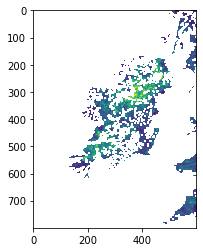

In [78]:
# e.g. for reading a single file:
print(len(filelist))
lai_file0 = get_lai(filelist[5],ncol=600,mincol=300,minrow=400,nrow=800) 
# if nothing is displayed, try a different filelist[3] or filelist[8].. etc
plt.imshow(lai_file0['Lai_1km'], vmin=0, vmax=5)

In [79]:
print((type(lai_file0)))
print((list(lai_file0.keys())))

<class 'dict'>
['Lai_1km', 'LaiStdDev_1km', 'FparLai_QC']


The function returns a dictionary with has keys `['Lai_1km', 'LaiStdDev_1km', 'FparLai_QC']`:

In [80]:
print((lai_file0['Lai_1km'].shape))

(800, 600)


Each of these datasets is of shape `(1200, 1200)`, but we have read only 600 (columns) and 800 (rows) in this case. Note that the numpy indexing is `(rows,cols)`.

We know how to create a mask from a vector dataset from the last session. First, we'll copy and unzip the global country shapefile:

In [81]:
%%bash
cd data
unzip -x -o ../../Chapter4_GDAL/data/ne_50m*zip
cd ..

Archive:  ../../Chapter4_GDAL/data/ne_50m_admin_0_countries.zip
  inflating: ne_50m_admin_0_countries.README.html  
 extracting: ne_50m_admin_0_countries.VERSION.txt  
 extracting: ne_50m_admin_0_countries.cpg  
  inflating: ne_50m_admin_0_countries.dbf  
  inflating: ne_50m_admin_0_countries.prj  
  inflating: ne_50m_admin_0_countries.shp  
  inflating: ne_50m_admin_0_countries.shx  


>>> Opened file HDF4_EOS:EOS_GRID:"data/MCD15A2.A2005241.h17v03.005.2008063115631.hdf":MOD_Grid_MOD15A2:Lai_1km
>>> Projection: PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
>>> File size 1200 rows, 1200 columns
>>> UL corner: -1.11195e+06, 6.6717e+06
Done!


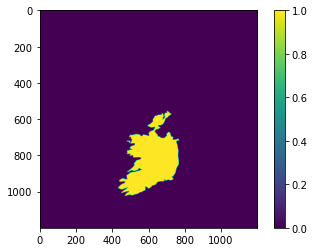

In [82]:
# have to make sure have access to gdal data files 
#from lai_library import rasterise_vector
# make a raster mask
# from the layer IRELAND in world.shp
from lai_library import rasterise_vector
filename = filelist[0]
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
file_spec = file_template%(filename,'Lai_1km')
     
mask = rasterise_vector ( file_spec, "data/ne_50m_admin_0_countries.shp", "NAME = 'IRELAND'", verbose=True)

mask = mask.astype(bool)
plt.imshow(mask)
plt.colorbar()

In this case, the data we want is only a small section of the whole spatial dataset.

It would be convenient to extract *only* the part we want.

We can use `numpy.where()` to help with this:

In [83]:
# The mask is True for the area we want
rowpix,colpix = np.where(mask == True)

print((rowpix,colpix))

(array([ 556,  556,  556, ..., 1022, 1022, 1022]), array([699, 700, 701, ..., 471, 472, 473]))


`rowpix` and `colpix` are lists of pixel coordinates where the condition we specified is `True` (i.e. where `mask` is `False`).

If we wanted to find the bounds of this area, we simply need to know the minimum and maximum column and row in these lists:

In [84]:
mincol,maxcol = min(colpix),max(colpix)
minrow,maxrow = min(rowpix),max(rowpix)

# think about why the + 1 here!!!
# what if maxcol and mincol were the same?
ncol = maxcol - mincol + 1
nrow = maxrow - minrow + 1

print((minrow,mincol,nrow,ncol))

(556, 431, 467, 335)


We could use this information to extract *only* the area we want when we read the data:

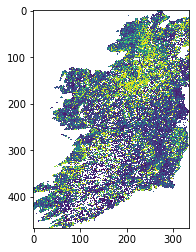

In [85]:
lai_file0 = get_lai(filelist[0],\
                    ncol=ncol,nrow=nrow,mincol=mincol,minrow=minrow)

plt.imshow(lai_file0['Lai_1km'],interpolation='none')

Now, lets extract this portion of the mask:

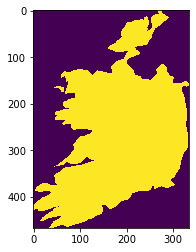

In [86]:
small_mask = mask[minrow:minrow+nrow,mincol:mincol+ncol]

plt.imshow(small_mask,interpolation='none')

And combine the country mask with the small dataset:

As a recap, we can use the function `rasterise_vector` that we gave you last time to develop a raster mask (!) from an ESRI shapefile (`ne_50m_admin_0_countries.shp` here).

We can then combine this mask with the QC-derived mask in the LAI dataset. We note that

1. The LAI mask (that will be the pixels which are set to `NaN` in the code below) is `False` for good data, if we use for example `np.isnan` to flag the `NaN`
2. The country mask is `True` within the selected country.

To combine them, we want some operator `X` for which:

    LAI            Country                       Result
    False(OK)      False (not Ireland)           False (invalid pixel)
    False(OK)      True (Ireland)                True (valid pixel)
    True (Bad LAI) False (not Ireland)           False (invalid pixel)
    True (Bad LAI) True ( Ireland)               False (invalid pixel)


We can obtain a simple binary relationship if we `NOT` the country mask, and `AND` it with the LAI mask:

    np.logical_and ( lai.mask, np.bitwise_not(small_mask))
    
If we want to use this mask in a masked array, remember that the mask is `True` if the pixel is masked, and `False` if it is unmasked. We can flip the mask over using e.g. `np.bitwise_not` when using it in the masked array.

However, it's easy to just carry on using `NaN` rather than a masked array.

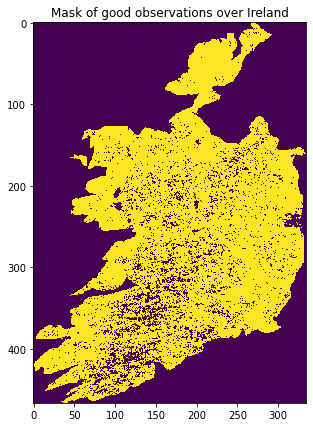

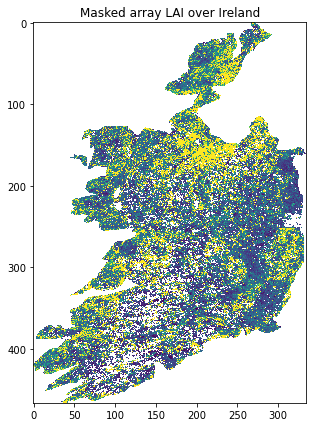

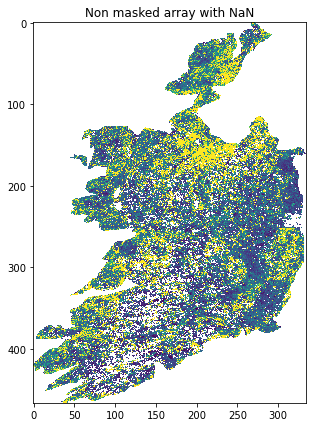

In [87]:
import numpy.ma as ma
lai_file0 = get_lai(filelist[0],
                    ncol=ncol,nrow=nrow,mincol=mincol,minrow=minrow)

layer = 'Lai_1km'
lai = lai_file0[layer]
small_mask = mask[minrow:minrow+nrow,mincol:mincol+ncol]

# combined mask
lai_mask = np.isnan(lai)
new_mask = np.logical_and(small_mask, np.logical_not(lai_mask))

plt.figure(figsize=(7,7))
plt.imshow(new_mask,interpolation='none')
plt.title("Mask of good observations over Ireland")

lai = ma.array(lai,mask=np.logical_not(new_mask))

plt.figure(figsize=(7,7))
plt.imshow(lai,vmin=0, vmax=5, interpolation='none')
plt.title("Masked array LAI over Ireland")

plt.figure(figsize=(7,7))
plt.title("Non masked array with NaN")
plt.imshow(lai*new_mask, vmin=0, vmax=5, interpolation="nearest")

We should be used to writing loops around such functions.

In this case, we read *all* of the files in `filelist` and put the data into the dictionary called `lai` here.

Because there are multiple layers in the datasets, we loop over layer and append to each list indiviually. But first, let's build the mask:

Done!


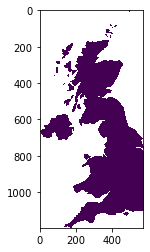

In [88]:
country = 'UNITED KINGDOM'

# make a raster mask
# from the layer UNITED KINGDOM in world.shp
filename = filelist[0]
file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
file_spec = file_template%(filename,'Lai_1km')
                           
mask = rasterise_vector ( file_spec, 
                         "data/ne_50m_admin_0_countries.shp", "NAME = '{}'".format(country), 
                         verbose=False)

# extract just the area we want
# by getting the min/max rows/cols
# of the data mask
# The mask is True for the area we want
rowpix,colpix = np.where(mask == True)
mincol,maxcol = min(colpix),max(colpix)
minrow,maxrow = min(rowpix),max(rowpix)
ncol = maxcol - mincol + 1
nrow = maxrow - minrow + 1
# and make a small mask
small_mask = mask[minrow:minrow+nrow, mincol:mincol+ncol]

small_mask = np.where(small_mask == 1, 1., np.nan)
plt.imshow(small_mask, interpolation="nearest")

In [89]:
data_fields = ['LaiStdDev_1km', 'Lai_1km']

# make a dictionary and put the filenames in it
# along with the mask and min/max info
# & data_fields with empty lists
lai = {'filenames':np.sort(filelist),
       'minrow':minrow,
       'mincol':mincol,
       'mask':small_mask, 
       'LaiStdDev_1km':[],
       'Lai_1km':[] }


# loop over each filename
for ii, f in enumerate(np.sort(lai['filenames'])):

    this_lai = get_lai(f,
                       mincol=mincol,ncol=ncol,
                       minrow=minrow,nrow=nrow)
    for layer in data_fields:
        # apply the mask
        lai_p = this_lai[layer]
        this_lai[layer] = lai_p*small_mask
        lai[layer].append(this_lai[layer])

(1197, 568)
2005161


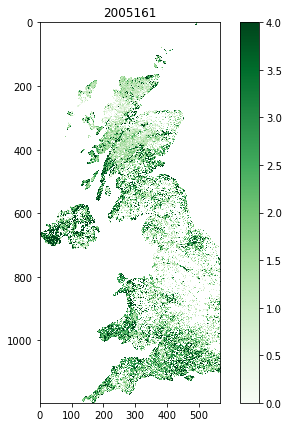

In [90]:
# have a look at one of these

i = 20

# just see what the shape is ...
print((lai['Lai_1km'][i].shape))

root = 'images/lai_uk'

cmap = plt.cm.Greens

f = lai['filenames'][i]
fig = plt.figure(figsize=(7,7))
# get some info from filename
file_id = f.split('/')[-1].split('.')[-5][1:]
print(file_id)
plt.imshow(lai['Lai_1km'][i],cmap=cmap,interpolation='none',vmax=4.,vmin=0.0)
# plot a jpg
plt.title(file_id)
plt.colorbar()
plt.savefig('images/lai_uk_%s.jpg'%file_id)

In [91]:
# thats quite good, so put as a function:
import numpy.ma as ma
import numpy as np
import sys
sys.path.insert(0,'python')
from lai_library import get_lai, rasterise_vector

def read_lai(filelist,country=None):
    '''
    Read MODIS LAI data from a set of files
    in the list filelist. Data assumed to be in
    directory datadir.
    
    Parameters:
    filelist : list of LAI files
    
    Options:
    country  : country name (in data/world.shp)
    
    Returns:
    lai dictionary
    '''
    if country:
        # make a raster mask
        # from the layer UNITED KINGDOM in world.shp
        filename = filelist[0]
        file_template = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_MOD15A2:%s'
        file_spec = file_template%(filename,'Lai_1km')

        mask = rasterise_vector ( file_spec, 
                                 "data/ne_50m_admin_0_countries.shp", "NAME = '{}'".format(country), 
                                 verbose=False)

        # extract just the area we want
        # by getting the min/max rows/cols
        # of the data mask
        # The mask is True for the area we want
        rowpix,colpix = np.where(mask == True)
        mincol,maxcol = min(colpix),max(colpix)
        minrow,maxrow = min(rowpix),max(rowpix)
        ncol = maxcol - mincol + 1
        nrow = maxrow - minrow + 1
        # and make a small mask
        small_mask = mask[minrow:minrow+nrow, mincol:mincol+ncol]

        small_mask = np.where(small_mask == 1, 1., np.nan)
    else:
        # no country
        mincol = 0
        maxcol = 0
        ncol = None
        nrow = None

    # data_fields with empty lists
    data_fields = ['LaiStdDev_1km','Lai_1km']
    
    # make a dictionary and put the filenames in it
    # along with the mask and min/max info
    lai = {'filenames':np.sort(filelist),
           'minrow':minrow,'mincol':mincol,
           'mask':small_mask, 
           'Lai_1km': [],
           'LaiStdDev_1km': []}
    

    
    # loop over each filename
    for f in np.sort(lai['filenames']):
        this_lai = get_lai(f,
                           mincol=mincol,ncol=ncol,
                           minrow=minrow,nrow=nrow)
        for layer in data_fields:
            if country:
                # apply the mask
                lai_p = this_lai[layer]
                this_lai[layer] = lai_p*small_mask
                lai[layer].append(this_lai[layer])
            else:
                lai_p = this_lai[layer]
                lai[layer].append(this_lai[layer])
            
    return lai

Done!
(467, 335)
2005161


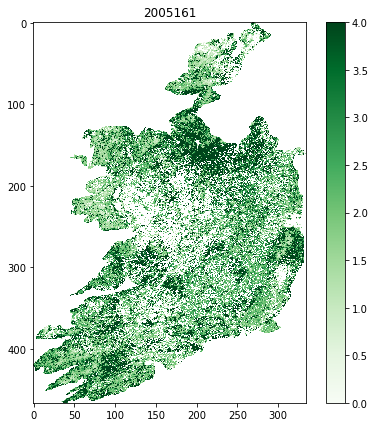

In [92]:
# test this ... the one in the file
# does a cutout of the data area as well
# which will keep the memory
# requirements down
#from get_lai import read_lai

lai = read_lai(filelist,country='IRELAND')

# have a look at one of these

i = 20

# just see what the shape is ...
print((lai['Lai_1km'][i].shape))

root = 'images/lai_eire'

cmap = plt.cm.Greens

f = lai['filenames'][i]
fig = plt.figure(figsize=(7,7))
# get some info from filename
file_id = f.split('/')[-1].split('.')[-5][1:]
print(file_id)
plt.imshow(lai['Lai_1km'][i],cmap=cmap,interpolation='none',vmax=4.,vmin=0.0)
# plot a jpg
plt.title(file_id)
plt.colorbar()
plt.savefig('%s_%s.jpg' % (root,file_id))

In [93]:
# make a movie

import pylab as plt
import os

# just see what the shape is ...
print((lai['Lai_1km'][0].shape))

root = 'images/lai_country_eire'

cmap = plt.cm.Greens

for i,f in enumerate(lai['filenames']):
    fig = plt.figure(figsize=(7,7))
    # get some info from filename
    file_id = f.split('/')[-1].split('.')[-5][1:]
    print(file_id)
    plt.imshow(lai['Lai_1km'][i],cmap=cmap,interpolation='none',vmax=4.,vmin=0.0)
    # plot a jpg
    plt.title(file_id)
    plt.colorbar()
    plt.savefig('%s_%s.jpg'%(root,file_id))
    plt.close(fig)
    
cmd = 'convert -delay 100 -loop 0 {0}_*.jpg {0}_movie.gif'.format(root)
os.system(cmd)

(467, 335)
2005001
2005009
2005017
2005025
2005033
2005041
2005049
2005057
2005065
2005073
2005081
2005089
2005097
2005105
2005113
2005121
2005129
2005137
2005145
2005153
2005161
2005169
2005177
2005185
2005193
2005201
2005209
2005217
2005225
2005233
2005241
2005249
2005257
2005265
2005273
2005281
2005289
2005297
2005305
2005313
2005321
2005329
2005337
2005345
2005353
2005361


0

![](files/images/lai_country_eire_movie.gif)

In [94]:
# The movie making works, so pack that into a function

import pylab as plt
import os

root = 'images/lai_eire'

def make_movie(lai,root,layer='Lai_1km',vmax=4.,vmin=0.,do_plot=False):
    '''
    Make an animated gif from MODIS LAI data in
    dictionary 'lai'.
    
    Parameters:
    lai    : data dictionary
    root   : root file /directory name of frames and movie
    
    layer  : data layer to plot 
    vmax   : max value for plotting
    vmin   : min value for plotting
    do_plot: set True if you want the individual plots
             to display
    
    Returns:
    movie name    
    
    '''
    cmap = plt.cm.Greens
    
    for i,f in enumerate(lai['filenames']):
        fig = plt.figure(figsize=(7,7))
        # get some info from filename
        file_id = f.split('/')[-1].split('.')[-5][1:]
        print(file_id)
        plt.imshow(lai[layer][i],cmap=cmap,interpolation='none',\
                   vmax=vmax,vmin=vmin)
        # plot a jpg
        plt.title(file_id)
        plt.colorbar()
        plt.savefig('%s_%s.jpg'%(root,file_id))
        if not do_plot:
            plt.close(fig)
        
    cmd = 'convert -delay 100 -loop 0 {0}_*.jpg {0}_movie.gif'.format(root)
    os.system(cmd)
    return '{0}_movie.gif'.format(root)

In [95]:
import glob
year = 2005
tile = "h17v03"
# test it
# Search for all the files using wildcards
filelist = glob.glob ("data/MCD15A2.A{}*{}*.hdf".format(year, tile))
filelist.sort()
lai_uk = read_lai(filelist,country='UNITED KINGDOM')
root = 'images/lai_UK'
movie = make_movie(lai_uk,root)
print(movie)

Done!
2005001
2005009
2005017
2005025
2005033
2005041
2005049
2005057
2005065
2005073
2005081
2005089
2005097
2005105
2005113
2005121
2005129
2005137
2005145
2005153
2005161
2005169
2005177
2005185
2005193
2005201
2005209
2005217
2005225
2005233
2005241
2005249
2005257
2005265
2005273
2005281
2005289
2005297
2005305
2005313
2005321
2005329
2005337
2005345
2005353
2005361
images/lai_UK_movie.gif


![](files/images/lai_UK_movie.gif)

## 5.2 Interpolation

### 5.2.1 Univariate interpolation

So, we can load the data we want from multiple MODIS hdf files that we have downloaded from the NASA server into a 3D masked numpy array, with a country boundary mask (projected int the raster data coordinate system) from a vector dataset.

Let's start to explore the data then.

You should have an array of LAI for Ireland:

In [96]:
type(lai['Lai_1km'])

list

Let's plot the LAI for some given pixels.

First, we might like to identify which pixels actually have any data.

A convenient function for this would be `np.where` that returns the indices of items that are `True`.

Since the data mask is `False` for good data, we take the complement `~` so that good data are `True:

In [97]:
data = np.array(lai['Lai_1km'])
np.where(np.isfinite(data))

(array([ 3,  3,  3, ..., 39, 39, 39]),
 array([318, 320, 321, ..., 466, 466, 466]),
 array([ 73, 136,  74, ...,  37,  40,  42]))

An example good pixel this is (3, 320, 136). Let's look at this for all time periods:

Text(0.5, 1.0, 'pixel 320 136')

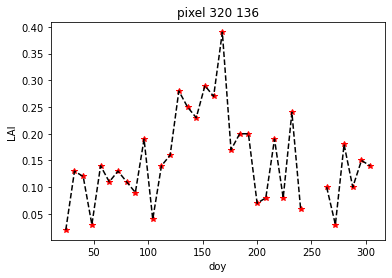

In [98]:
r = 320
c = 136

pixel = data[:, r, c]/10. 

# plot red stars at the data points
plt.plot(np.arange(len(pixel))*8,pixel,'r*')
# plot a black (k) dashed line (--)
plt.plot(np.arange(len(pixel))*8,pixel,'k--')
plt.xlabel('doy')
plt.ylabel('LAI')
plt.title('pixel %03d %03d'%(r,c))

The data follow the trend of what we might expect for LAI development, but they are clearly a little noisy.

We also have access to uncertainty information (standard deviation):

Text(0.5, 1.0, 'pixel 320 136')

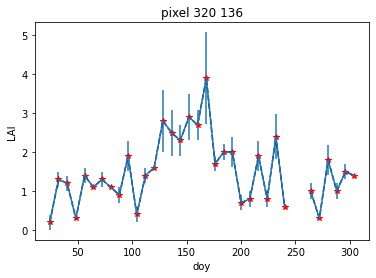

In [99]:
# copy the data in case we change it any

data = np.array(lai['Lai_1km']) * 1.
sd   = np.array(lai['LaiStdDev_1km'])*1.

r = 320
c = 136

pixel    = data[:,r,c]
pixel_sd =   sd[:,r,c]

x = np.arange(len(pixel))*8

# plot red stars at the data points
plt.plot(x,pixel,'r*')
# plot a black (k) dashed line (--)
plt.plot(x,pixel,'k--')
# plot error bars:
# 1.96 because that is the 95% confidence interval
plt.errorbar(x,pixel,yerr=pixel_sd*1.96)
plt.xlabel('doy')
plt.ylabel('LAI')
plt.title('pixel %03d %03d'%(r,c))

We would generally expect LAI to be quite smoothly varying over time. Visualising the data with 95% confidence intervals is quite useful as we can now 'imagine' some smooth line that would generally go within these bounds.

Some of the uncertainty estimates are really rather small though, which are probably not reliable.

Let's inflate them:



Text(0.5, 1.0, 'pixel 320 136')

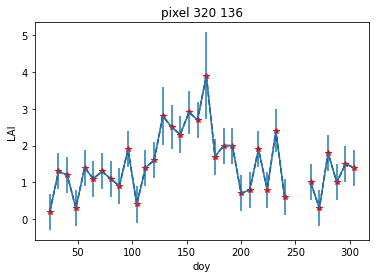

In [100]:
# copy the data in case we change it any

data = np.array(lai['Lai_1km']) * 1.
sd   = np.array(lai['LaiStdDev_1km'])*1.
r = 320
c = 136

pixel    = data[:,r,c]
pixel_sd =   sd[:,r,c]
# threshold
thresh = 0.25
pixel_sd[pixel_sd<thresh] = thresh

x = np.arange(len(pixel))*8

# plot red stars at the data points
plt.plot(x,pixel,'r*')
# plot a black (k) dashed line (--)
plt.plot(x,pixel,'k--')
# plot error bars:
# 1.96 because that is the 95% confidence interval
plt.errorbar(x,pixel,yerr=pixel_sd*1.96)
plt.xlabel('doy')
plt.ylabel('LAI')
plt.title('pixel %03d %03d'%(r,c))

This is perhaps a bit more realistic ...

The data now have some missing values (data gaps) and, as we have noted, are a little noisy.

A Python module we can use for many scientific functions is [`scipy`](http://docs.scipy.org/doc/scipy), in particular here, the [`scipy` interpolation functions](http://docs.scipy.org/doc/scipy/reference/interpolate.html).

We need to make a careful choice of the interpolation functions.

We might, in many circumstances simply want something that interpolates between data points, i.e. that goes through the data points that we have.

Many interpolators will not provide extrapolation, so in the example above we could not get an estimate of LAI prior to the first sample and after the last.

The best way to deal with that would be to have multiple years of data.

Instead here, we will repeat the dataset three times to mimic this:


In [101]:
from scipy import interpolate

pixel = data[:,r,c]

# original x,y
y_ = pixel
x_ = (np.arange(len(y_))*8.+1)[np.isfinite(pixel)]
y_ = y_[np.isfinite(pixel)]

# extend: using np.tile() to repeat data
y_extend = np.tile(y_,3)
# extend: using vstack to stack 3 different arrays
x_extend = np.hstack((x_-46*8,x_,x_+46*8))

Text(0, 0.5, 'LAI')

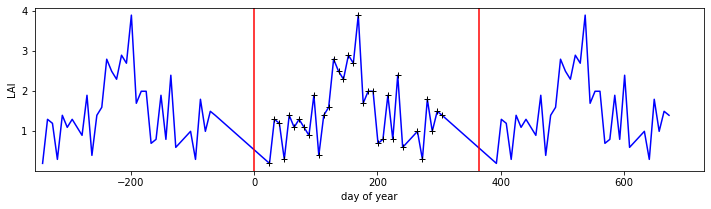

In [102]:
# plot the extended dataset
plt.figure(figsize=(12,3))
plt.plot(x_extend,y_extend,'b')
plt.plot(x_,y_,'k+')
plt.axvline(0, color="r")
plt.axvline(365, color="r")
plt.xlim(-356,2*365)
plt.xlabel('day of year')
plt.ylabel('LAI')

In [103]:
# define xnew at 1 day interval
xnew = np.arange(1.,366.)

# linear interpolation
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
ynew = f(xnew)

(1.0, 366.0)

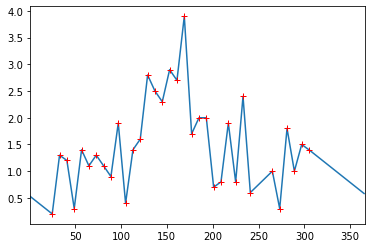

In [104]:
plt.plot(xnew,ynew)
plt.plot(x_,y_,'r+')
plt.xlim(1,366)

(1.0, 366.0)

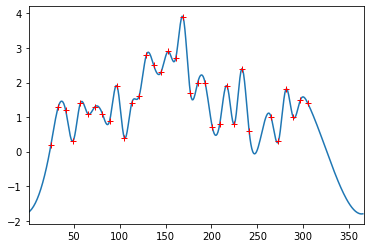

In [105]:
# cubic interpolation
f = interpolate.interp1d(x_extend,y_extend,kind='cubic')
ynew = f(xnew)
plt.plot(xnew,ynew)
plt.plot(x_,y_,'r+')
plt.xlim(1,366)

(1.0, 366.0)

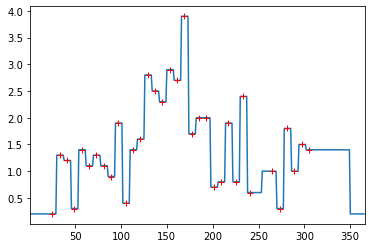

In [106]:
# nearest neighbour interpolation
f = interpolate.interp1d(x_extend,y_extend,kind='nearest')
ynew = f(xnew)
plt.plot(xnew,ynew)
plt.plot(x_,y_,'r+')
plt.xlim(1,366)

Depending on the problem you are trying to solve, different interpolation schemes will be appropriate. For categorical data (e.g. 'snow', coded as 1 and 'no snow' coded as 1), for instance, a nearest neighbour interpolation might be a good idea.

### 5.2.2 Smoothing

One issue with the schemes above is that they go exactly through the data points, but a more realistic description of the data might be one that incorporated the uncertainty information we have. Visually, this is quite easy to imagine, but how can we implement such ideas?

One way of thinking about this is to think about other sources of information that we might bring to bear on the problem. One such would be that we expect the function to be 'quite smooth'. This allows us to consider applying smoothness as an additional constraint to the solution.

Many such problems can be phrased as convolution operations.

Convolution is a form of digital filtering that combines two sequences of numbers $y$ and $w$ to give a third, the result $z$ that is a filtered version of $y$, where for each element $j$ of $y$:

$$
  z_j = \sum_{i=-n}^{i=n}{w_i y_{j+i}}
$$

where $n$ is the half width of the filter $w$. For a smoothing filter, the elements of this will sum to 1 (so that the magnitude of $y$ is not changed).

To illustrate this in Python:



In [150]:
# a simple box smoothing filter
# filter width 11
w = np.ones(11)
# normalise
w = w/w.sum()
print(len(w))
# half width
n = int(len(w)/2)


# Take the linear interpolation of the LAI above as the signal 
# linear interpolation
x = xnew
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
y = f(x)

# where we will put the result
z = np.zeros_like(y)


# This is a straight implementation of the
# equation above
for j in range(n,len(y)-n):
    for i in range(-n,n+1):
        z[j] += w[n+i] * y[j+i]

11


Text(0.5, 1.0, 'smoothing with filter width 11')

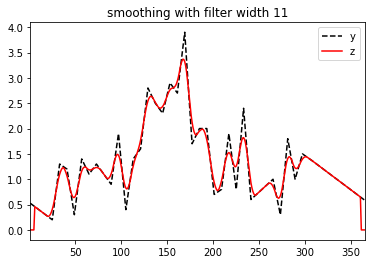

In [151]:
plt.plot(x,y,'k--',label='y')
plt.plot(x,z,'r',label='z')
plt.xlim(x[0],x[-1])
plt.legend(loc='best')
plt.title('smoothing with filter width %d'%len(w))

As we suggested, the result of convolving $y$ with the filter $w$ (of width 31 here) is $z$, a smoothed version of $y$.

You might notice that the filter is only applied once we are `n` samples into the signal, so we get 'edge effects'. There are various ways of dealing with edge effects, such as repeating the signal (as we did above, for much the same reason), reflecting the signal, or assuming the signal to be some constant value (e.g. 0) outside of its defined domain.

If we make the filter wider (width 31 now):

Text(0.5, 1.0, 'smoothing with filter width 31')

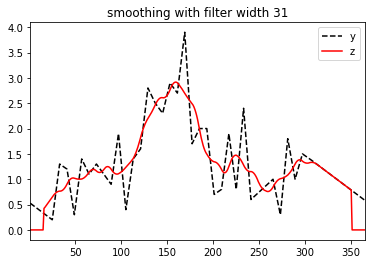

In [152]:
# a simple box smoothing filter
# filter width 31
w = np.ones(31)
# normalise
w = w/w.sum()
# half width
n = int(len(w)/2)

# Take the linear interpolation of the LAI above as the signal 
# linear interpolation
x = xnew
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
y = f(x)

# where we will put the result
z = np.zeros_like(y)

# This is a straight implementation of the
# equation above
for j in range(n,len(y)-n):
    for i in range(-n,n+1):
        z[j] += w[n+i] * y[j+i]
        
plt.plot(x,y,'k--',label='y')
plt.plot(x,z,'r',label='z')
plt.xlim(x[0],x[-1])
plt.legend(loc='best')
plt.title('smoothing with filter width %d'%len(w))

Then the signal is 'more' smoothed. 

There are *many* filters implemented in [`scipy.signal`](http://docs.scipy.org/doc/scipy/reference/signal.html) that you should look over.

A very commonly used smoothing filter is the [Savitsky-Golay](http://en.wikipedia.org/wiki/Savitzky–Golay_filter_for_smoothing_and_differentiation) filter for which you define the window size and filter order.

As with most filters, the filter width controls the degree of smoothing (see examples above). The filter order (related to polynomial order) in essence controls the shape of the filter and defines the 'peakiness' of the response.

Text(0.5, 1.0, 'smoothing with filter width 31 order 1.00')

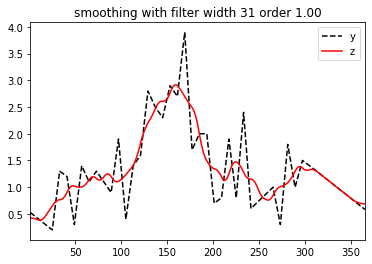

In [153]:
import sys
sys.path.insert(0,'python')
# see http://wiki.scipy.org/Cookbook/SavitzkyGolay
from savitzky_golay import *

window_size = 31
order = 1

# Take the linear interpolation of the LAI above as the signal 
# linear interpolation
x = xnew
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
y = f(x)

z = savitzky_golay(y,window_size,order)

plt.plot(x,y,'k--',label='y')
plt.plot(x,z,'r',label='z')
plt.xlim(x[0],x[-1])
plt.legend(loc='best')
plt.title('smoothing with filter width %d order %.2f'%(window_size,order))

Text(0.5, 1.0, 'smoothing with filter width 61 order 2.00')

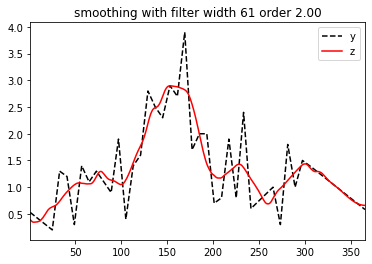

In [154]:
import sys
sys.path.insert(0,'python')
# see http://wiki.scipy.org/Cookbook/SavitzkyGolay
from savitzky_golay import *

window_size = 61
order = 2

# Take the linear interpolation of the LAI above as the signal 
# linear interpolation
x = xnew
f = interpolate.interp1d(x_extend,y_extend,kind='linear')
y = f(x)

z = savitzky_golay(y,window_size,order)

plt.plot(x,y,'k--',label='y')
plt.plot(x,z,'r',label='z')
plt.xlim(x[0],x[-1])
plt.legend(loc='best')
plt.title('smoothing with filter width %d order %.2f'%(window_size,order))

If the samples $y$ have uncertainty (standard deviation $\sigma_j$ for sample $j$) associated with them, we can incorporate this into smoothing, although many of the methods in `scipy` and `numpy` do not directly allow for this.

Instead, we call an optimal interpolation scheme (a regulariser) here that achieves this. This also has the advantage of giving an estimate of uncertainty for the smoothed samples.

In this case, the parameters are: `order` (as above, but only integer in this implementation) and `wsd` which is an estimate of the variation (standard deviation) in the signal that control smoothness.

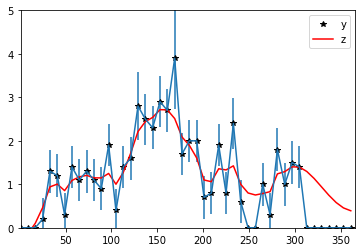

In [155]:
import glob
from smoothn import *
tile = 'h17v03'
year = '2005'

# Search for all the files using wildcards
filelist = glob.glob ("data/MCD15A2.A{}*{}*.hdf".format(year, tile))
filelist.sort()

try:
    data = np.array(lai['Lai_1km'])
    sd = np.array(lai['LaiStdDev_1km'])
except:
    lai = read_lai(filelist,country='IRELAND')
    data = np.array(lai['Lai_1km'])
    sd = np.array(lai['LaiStdDev_1km'])
    
thresh = 0.25
sd[sd<thresh] = thresh

#print np.where(np.isfinite(data))
r = 320
c = 136

# this is about the right amount of smoothing here
gamma = .7

pixel = data[:,r,c]
pixel_sd = sd[:,r,c]

#pixel[np.isnan(pixel)] = 0.
#pixel_sd[np.isnan(pixel_sd)] = 0.




x = np.arange(46)*8+1

order = 2
z = smoothn(pixel, s=gamma, sd=pixel_sd, smoothOrder=2.0)[0]

# plot
plt.plot(x,pixel,'k*',label='y')
plt.errorbar(x,pixel,pixel_sd*1.96)
plt.plot(x,z,'r',label='z')
# lower and upper bounds of 95% CI

plt.xlim(1,366)
plt.ylim(0.,5)
plt.legend(loc='best')

1

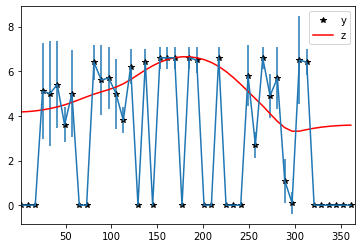

In [156]:
# test it on a new pixel

r = 432
c = 86

gamma = 5

pixel = data[:,r,c]
pixel_sd =   sd[:,r,c]

x = np.arange(46)*8+1

order = 2
z = smoothn(pixel,s=gamma,sd=pixel_sd,smoothOrder=2.0)[0]

# plot
plt.plot(x,pixel,'k*',label='y')
plt.errorbar(x,pixel,pixel_sd*1.96)
plt.plot(x,z,'r',label='z')

plt.xlim(1,366)
plt.legend(loc='best')
z.ndim

(0.6523134108162423, True)


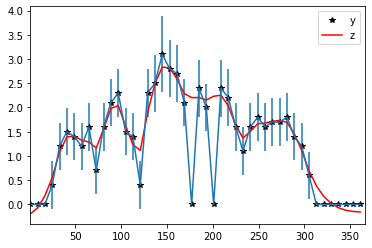

In [157]:
# and test it on a new pixel

r = 372
c = 56

#r = 9
#c = 277
gamma = .1

pixel = data[:,r,c]
pixel_sd =   sd[:,r,c]

x = np.arange(46)*8+1

order = 2
# solve for gamma - degree of smoothness 
zz = smoothn(pixel,sd=pixel_sd,smoothOrder=2.0)
z = zz[0]
print((zz[1],zz[2]))

gamma = zz[1]

# plot
plt.plot(x,pixel,'k*',label='y')
plt.errorbar(x,pixel,pixel_sd*1.96)
plt.plot(x,z,'r',label='z')

plt.xlim(1,366)
plt.legend(loc='best')

To apply this approach to our 3D dataset, we could simply loop over all pixels.

Note that *any* per-pixel processing will be slow ... but this is quite a fast smoothing method, so is feasible here.

In [159]:
# we have put in an axis control to smoothn
# here so it will only smooth over doy
# This will take a few minutes to process
# we switch on verbose mode to get some feedback
# on progress

# make a mask of pixels where there is at least 1 sample
# over the time period
#data2 = data.copy()
#mask = (data2.mask.sum(axis=0) == 0)
#mask = np.array([mask]*data2.shape[0])

z = smoothn(data,s=5.0,sd=sd,smoothOrder=2.0,axis=0,TolZ=0.05,verbose=True)[0]
#z = ma.array(z,mask=mask)

('tol', 1.0, 'nit', 0)
('tol', 1.034685779909397, 'nit', 1)
('tol', 0.6940053346625661, 'nit', 2)
('tol', 0.5526638196718451, 'nit', 3)
('tol', 0.37861770513958637, 'nit', 4)
('tol', 0.2968615988690677, 'nit', 5)
('tol', 0.21107736939692529, 'nit', 6)
('tol', 0.16158342445865, 'nit', 7)
('tol', 0.11794077521390071, 'nit', 8)
('tol', 0.08908341401486107, 'nit', 9)
('tol', 0.06619736361645151, 'nit', 10)


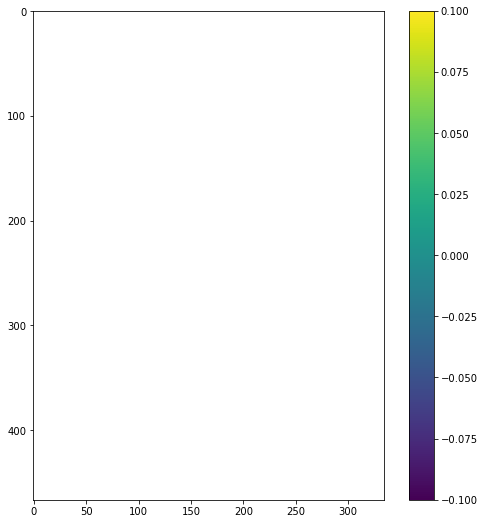

In [148]:
plt.figure(figsize=(9,9))
plt.imshow(z[3],interpolation='none',vmax=6)
plt.colorbar()

('s =', 0.756616274544016)


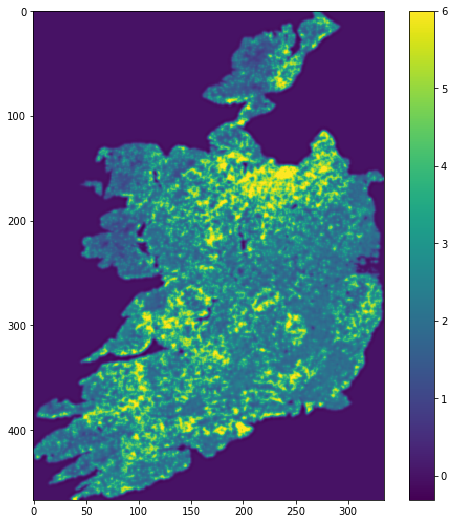

In [128]:
# similarly, take frame 20
# and smooth that

ZZ = smoothn(z[20],smoothOrder=2.)
# self-calibrated smoothness term
s = ZZ[1]
print(('s =',s))
Z = ZZ[0]
plt.figure(figsize=(9,9))
plt.imshow(Z,interpolation='none',vmax=6)
plt.colorbar()

('tol', 1.0, 'nit', 0)


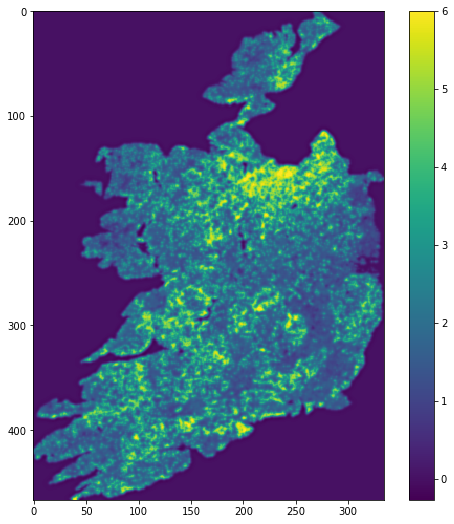

In [129]:
# similarly, take frame 20
# and smooth that

ZZ = smoothn(z,s=s,smoothOrder=2.,axis=(1,2),verbose=True)

Z = ZZ[0]
plt.figure(figsize=(9,9))
plt.imshow(Z[30],interpolation='none',vmax=6)
plt.colorbar()

Text(0.5, 1.0, 'LAI variation of Eire')

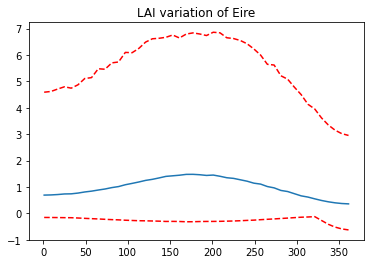

In [130]:
x = np.arange(46)*8+1.
try:
    plt.plot(x,np.mean(Z,axis=(1,2)))
    plt.plot(x,np.min(Z,axis=(1,2)),'r--')
    plt.plot(x,np.max(Z,axis=(1,2)),'r--')
except:
    plt.plot(x,np.mean(Z,axis=2).mean(axis=1))
    plt.plot(x,np.min(Z,axis=2).min(axis=1),'r--')
    plt.plot(x,np.max(Z,axis=2).max(axis=1),'r--')
    
plt.title('LAI variation of Eire')

In [160]:
import pylab as plt
import os

root = 'images/lai_eire_colourZ'

for i,f in enumerate(lai['filenames']):
    fig = plt.figure(figsize=(7,7))
    # get some info from filename
    file_id = f.split('/')[-1].split('.')[-5][1:]
    print(file_id)
    plt.imshow(Z[i],interpolation='none',vmax=6.,vmin=0.0)
    # plot a jpg
    plt.title(file_id)
    plt.colorbar()
    plt.savefig('%s_%s.jpg'%(root,file_id))
    plt.close(fig)

2005001
2005009
2005017
2005025
2005033
2005041
2005049
2005057
2005065
2005073
2005081
2005089
2005097
2005105
2005113
2005121
2005129
2005137
2005145
2005153
2005161
2005169
2005177
2005185
2005193
2005201
2005209
2005217
2005225
2005233
2005241
2005249
2005257
2005265
2005273
2005281
2005289
2005297
2005305
2005313
2005321
2005329
2005337
2005345
2005353
2005361


In [161]:
cmd = 'convert -delay 100 -loop 0 {0}_*.jpg {0}_movie2.gif'.format(root)
os.system(cmd)

0

![](files/images/lai_eire_colourZ_movie2.gif)

### 5.3 Function fitting

**BA:** Struggled to get the logistic function working with this data. May require major refactor.
See https://github.com/ucfa/geogg122/blob/master/Chapter5_Interpolation/Interpolation.ipynb
for how this looks

Sometimes, instead of applying some arbitrary smoothing function to data, we want to extract particular infromation from the time series.

One way to approach this is to fit some function to the time series at each location.

Let us suppose that we wish to characterise the phenology of vegetation in Ireland.

![](http://www2.geog.ucl.ac.uk/~plewis/geogg124/_images/zhang1.png)

One way we could do this would be to look in the lai data for the most rapid changes.

Another would be to explicitly fit some mathematical function to the LAI data that would would expect to describe typical LAI trajectories.

One example of such a function is the double logistic. A logistic function is:

$$
 \hat{y} = p_0 - p_1 \left( \frac{1}{1 + e^{p_2 (t - p_3)}} + \frac{1}{1 + e^{p_4 (t - p_5)}} -1\right)
$$




We can give a function for a double logistic:

In [303]:
def dbl_logistic_model ( p, t ):
        """A double logistic model, as in Sobrino and Juliean, 
        or Zhang et al"""
        return p[0] - p[1]* ( 1./(1+np.exp(p[2]*(t-p[3]))) + \
                              1./(1+np.exp(-p[4]*(t-p[5])))  - 1 )

In [321]:
tile = 'h17v03'
year = '2005'

# specify the file with the urls in
ifile= 'data/modis_lai_%s_%s.txt'%(tile,year)

fp = open(ifile)
filelist = [url.split('/')[-1].strip() for url in fp.readlines()]
fp.close()
import sys
sys.path.insert(0,'python')

from get_lai import *
# lists MUST be converted to numpy arrays IOT slice correctly!
try:
    data = np.array(lai['Lai_1km'])
    sd = np.array(lai['LaiStdDev_1km'])
except:
    lai = read_lai(filelist,country='IRELAND')
    data = np.array(lai['Lai_1km'])
    sd = np.array(lai['LaiStdDev_1km'])


thresh = 0.25
sd[sd <thresh] = thresh

# test pixel
r = 452
c = 84

#print(data[0][1,1])
#print(data[1:, 0:2, 1:4])
#print(type(data[:][r,c]))

# old code prior to grabbing from model_fitting notebook
#y = data[:,r,c]
#print(y.astype(int))
#y_mask = np.logical_not(y.astype(int))
#mask = ~y.lai['mask']
#mask = ma.array(y, mask=y_mask)

y = data[:,r,c]
mask = np.logical_not(np.isnan(y))
y = np.array(y[mask])
x = (np.arange(46)*8+1.)[mask]
unc = np.array(sd[:,r,c][mask])


#y = np.array(y)
#x = (np.arange(46)*8+1.)
#unc = np.array(sd[:,r,c])

print(unc)


[1.2  0.25 1.1  1.3  0.4  0.5  0.4  0.8  0.5  0.4  0.4  0.4  0.25 0.4
 0.25 0.7  0.25 0.4  0.25 0.4  0.4  0.6  0.4  0.25 0.25 1.1  0.25]


And see what this looks like:

<ErrorbarContainer object of 3 artists>

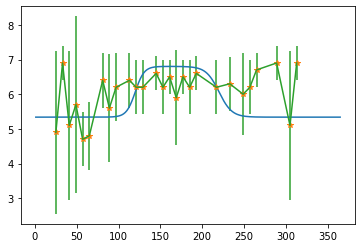

In [322]:
# define x (time)
x_full = np.arange(1,366) 

# some default values for the parameters
p = np.zeros(6)

# some stats on y
ysd = np.std(y)
ymean = np.mean(y)

# some rough guesses at the parameters

p[0] = ymean - 1.151*ysd;   # minimum  (1.151 is 75% CI)
p[1] = 2*1.151*ysd          # range
p[2] = 0.19                 # related to up slope
p[3] = 120                  # midpoint of up slope
p[4] = 0.13                 # related to down slope
p[5] = 220                  # midpoint of down slope

y_hat = dbl_logistic_model(p,x_full)

plt.clf()
plt.plot(x_full,y_hat)
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)

We could manually 'tweak' the parameters until we got a better 'fit' to the observations.

First though, let's define a measure of 'fit':

$$
Z_i = \frac{\hat{y}_i - y_i}{\sigma_i}
$$

$$
Z^2 = \sum_i{Z_i^2} =  \sum_i{\left( \frac{\hat{y}_i - y_i}{\sigma_i} \right)^2}
$$

and implement this as a mismatch function where we have data points:

('Z^2 =', 183.84117717856537)


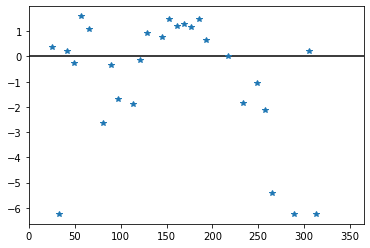

In [323]:
def mismatch_function(p, x, y, unc):
    y_hat = dbl_logistic_model(p, x)
    diff = (y_hat - y)/unc
    return diff


Z = mismatch_function(p,x,y,unc)

plt.plot([1,365.],[0,0.],'k-')
plt.xlim(0,365)
plt.plot(x,Z,'*')


print(('Z^2 =',(Z**2).sum()))

Now lets change p a bit:

('Z^2 =', 192.79543044379074)


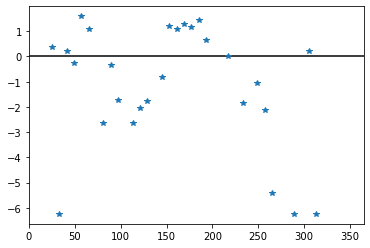

In [324]:
p[0] = ymean - 1.151*ysd;   # minimum  (1.151 is 75% CI)
p[1] = 2*1.151*ysd          # range
p[2] = 0.19                 # related to up slope
p[3] = 140                  # midpoint of up slope
p[4] = 0.13                 # related to down slope
p[5] = 220                  # midpoint of down slope

Z = mismatch_function(p,x,y,unc)

plt.plot([1,365.],[0,0.],'k-')
plt.xlim(0,365)
plt.plot(x,Z,'*')


print(('Z^2 =',(Z**2).sum()))

We have made the mismatch go down a little ...

Clearly it would be tedious (and impractical) to do a lot of such tweaking, so we can use methods that seek the minimum of some function.

One such method is implemented in `scipy.optimize.leastsq`:

('initial parameters:', 5.338505166994634, 1.4637304067514731, 0.19, 140.0, 0.13, 220.0)
177.19472293525715
('solved parameters: ', 1.7507651349973194, 4.833677974509382, 1.0, 139.5103237681379, 0.06357793932077263, 266.96338363000274)
('phenology', 139.5103237681379, 127.45305986186483)


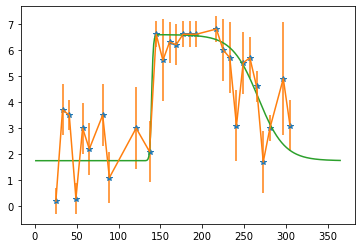

In [326]:
from scipy import optimize

# initial estimate is in p
print(('initial parameters:',p[0],p[1],p[2],p[3],p[4],p[5]))

# set some bounds for the parameters
bound = np.array([(0.,10.),(0.,10.),(0.01,1.),\
                  (50.,300.),(0.01,1.),(50.,300.)])


# test pixel
r = 416
c = 84


y = data[:,r,c]
mask = np.logical_not(np.isnan(y))
y = np.array(y[mask])
x = (np.arange(46)*8+1.)[mask]
unc = np.array(sd[:,r,c][mask])

# define function to give Z^2

def sse(p,x,y,unc):
    '''Sum of squared error'''
    # penalise p[3] > p[5]
    err = np.max([0.,(p[3] - p[5])])*1e4
    return (mismatch_function(p,x,y,unc)**2).sum()+err

# we pass the function:
#
# sse               : the name of the function we wrote to give 
#                     sum of squares of Z_i
# p                 : an initial estimate of the parameters
# args=(x,y,unc)    : the other information (other than p) that
#                     mismatch_function needs
# approx_grad       : if we dont have a function for the gradien
#                     we have to get the solver to approximate it
#                     which takes time ... see if you can work out
#                     d_sse / dp and use that to speed this up!

psolve = optimize.fmin_l_bfgs_b(sse,p,approx_grad=True,iprint=-1,\
                                args=(x,y,unc),bounds=bound)

print((psolve[1]))
pp = psolve[0]
plt.plot(x,y,'*')
plt.errorbar(x,y,unc*1.96)
y_hat = dbl_logistic_model(pp,x_full)
plt.plot(x_full,y_hat)

print(('solved parameters: ',pp[0],pp[1],pp[2],pp[3],pp[4],pp[5]))

# if we define the phenology as the parameter p[3]
# and the 'length' of the growing season:
print(('phenology',pp[3],pp[5]-pp[3]))

In [ ]:
# and run over each pixel ... this will take some time

# pixels that have some data
np.logical_not(np.isnan(y))
mask = np.logical_not(np.isnan(data)).sum(axis=0)

pdata = np.zeros((7,) + mask.shape)

rows,cols = np.where(mask>0)
len_x = len(rows)

# lets just do some random ones to start with
#rows = rows[::10]
#cols = cols[::10]

len_x = len(rows)


for i in range(len_x):
    r,c = rows[i],cols[i]
    # progress bar
    if i%(len_x/40) == 0:
        print(('... %4.2f percent'%(i*100./float(len_x))))
    
    
    y = data[:,r,c]
    mask = np.logical_not(np.isnan(y))
    y = np.array(y[mask])
    x = (np.arange(46)*8+1.)[mask]
    unc = np.array(sd[:,r,c][mask])
    
    # need to get an initial estimate of the parameters
    
    # some stats on y
    ysd = np.std(y)
    ymean = np.mean(y)

    p[0] = ymean - 1.151*ysd;   # minimum  (1.151 is 75% CI)
    p[1] = 2*1.151*ysd          # range
    p[2] = 0.19                 # related to up slope
    p[3] = 140                  # midpoint of up slope
    p[4] = 0.13                 # related to down slope
    p[5] = 220                  # midpoint of down slope

    
    # set factr to quite large number (relative error in solution)
    # as it'll take too long otherwise
    psolve = optimize.fmin_l_bfgs_b(sse,p,approx_grad=True,iprint=-1,\
                                args=(x,y,unc),bounds=bound,factr=1e12)

    pdata[:-1,rows[i],cols[i]] = psolve[0]
    pdata[-1,rows[i],cols[i]] = psolve[1] # sse

... 0.00 percent


In [308]:
plt.figure(figsize=(10,10))
plt.imshow(pdata[3],interpolation='none',vmin=137,vmax=141)
plt.title('green up doy')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(pdata[5]-pdata[3],interpolation='none',vmin=74,vmax=84)
plt.title('season length')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(pdata[0],interpolation='none',vmin=0.,vmax=6.)
plt.title('min LAI')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(pdata[1]+pdata[0],interpolation='none',vmin=0.,vmax=6.)
plt.title('max LAI')
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(np.sqrt(pdata[-1]),interpolation='none',vmax=np.sqrt(500))
plt.title('RSSE')
plt.colorbar()

NameError: name 'pdata' is not defined

<Figure size 720x720 with 0 Axes>

In [309]:
# check a few pixels

c = 200

for r in range(200,400,25):
    y = data[:,r,c]
    mask = ~y.mask
    y = np.array(y[mask])
    x = (np.arange(46)*8+1.)[mask]
    unc = np.array(sd[:,r,c][mask])
    
    x_full = np.arange(1,366) 
    
    # some default values for the parameters
    pp = pdata[:-1,r,c]
    plt.figure(figsize=(7,7))
    plt.title('r %d c %d'%(r,c))
    plt.plot(x,y,'*')
    plt.errorbar(x,y,unc*1.96)
    y_hat = dbl_logistic_model(pp,x_full)
    plt.plot(x_full,y_hat)
    
    print(('solved parameters: ',pp[0],pp[1],pp[2],pp[3],pp[4],pp[5]))
    
    # if we define the phenology as the parameter p[3]
    # and the 'length' of the growing season:
    print(('phenology',pp[3],pp[5]-pp[3]))

AttributeError: 'numpy.ndarray' object has no attribute 'mask'